In [15]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import copy

from skimage.transform import resize, pyramid_gaussian
import sklearn.linear_model


import zarr

import os
import sys
import re

import openslide

from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay



In [2]:

## https://stackoverflow.com/questions/2148543/how-to-write-a-confusion-matrix
def compute_confusion_matrix(true, pred):
  '''Computes a confusion matrix using numpy for two np.arrays
  true and pred.
  Results are identical (and similar in computation time) to: 
  "from sklearn.metrics import confusion_matrix"
  However, this function avoids the dependency on sklearn.'''
  K = len(np.unique(true)) # Number of classes 
  result = np.zeros((K, K))
  for i in range(len(true)):
    result[true[i]][pred[i]] += 1
  return result


In [38]:

slide_meta = pd.read_csv("../metadata/labels_with_new_batch.csv")
ct_scoring = pd.read_csv("../metadata/CT_3_Class_Draft.csv")



ct_scoring["txt_idat"] = ct_scoring["idat"].astype("str")
ct_scoring.index = ct_scoring.txt_idat
slide_meta.index = slide_meta.idat
ct_scoring = ct_scoring.drop("txt_idat", axis=1)
slide_meta = slide_meta.drop("idat", axis=1)
slide_annots = slide_meta.join(ct_scoring, lsuffix="l")


slide_annots['file'] = slide_annots.uuid + ".h5"


train_set = pd.read_csv('/home/p163v/histopathology/runs/run2/' + "/train_set_01.txt")
valid_set = pd.read_csv('/home/p163v/histopathology/runs/run2/' + "/valid_set_01.txt")


train_files = train_set.loc[train_set["patches"]>=250].File.tolist()
valid_files = valid_set.loc[valid_set["patches"]>=250].File.tolist()

train_annot = copy.copy(slide_annots.loc[[x in train_files for x in slide_annots.file]])
valid_annot = copy.copy(slide_annots.loc[[x in valid_files for x in slide_annots.file]])

train_labels = np.abs(1-train_annot.CT_class.factorize(sort=True)[0])
valid_labels = np.abs(1-valid_annot.CT_class.factorize(sort=True)[0])


In [39]:
slide_annots.groupby('family').count()

,uuid,tumor_id,txt_LOKALISATION,num_ALTERSANGABE,patient_id,max_super_family_class,max_family_class,max_class,max_subclass,relevant Histo prediction,possible further consolidation,classifciation_v11,max_cal_v11,file_path,slide,Unnamed: 0,idat,CT_class,file
family,,,,,,,,,,,,,,,,,,,
diffuse leptomeningeal glioneuronal tumor,24,24,22,20,24,24,24,24,24,24,24,24,24,15,24,24,24,24,24
ATRT,127,127,97,78,127,127,127,127,127,127,127,127,127,114,127,117,117,117,127
PA and other MAPK LGGNT,500,500,489,451,500,500,500,500,500,500,500,500,500,443,500,491,491,491,500
astrocytoma,346,346,331,311,346,346,346,346,346,346,346,346,346,315,346,336,336,336,346
chordoid glioma,17,17,14,16,17,17,17,17,17,17,17,17,17,12,17,17,17,17,17
chordoma,39,39,38,36,39,39,39,39,39,39,39,39,39,37,39,35,35,35,39
control,351,351,326,297,351,351,351,351,351,351,351,351,351,324,351,329,329,329,351
craniopharyngioma,316,316,304,194,316,316,316,316,316,316,316,316,316,304,316,314,314,314,316
diffuse midline glioma H3 K27M mutant,129,129,107,100,129,129,129,129,129,129,129,129,129,106,129,120,120,120,129


In [40]:
valid_probs = pd.read_csv('/home/p163v/histopathology/runs/run2/' + 'valid_set_1_probs.csv', header=None)
valid_probs = np.array(valid_probs)
valid_preds = pd.read_csv('/home/p163v/histopathology/runs/run2/' + 'valid_set_1_preds.csv', header=None)
valid_preds = np.array(valid_preds)

train_probs = pd.read_csv('../runs/run2/train_set_1_probs.csv', header=None)
train_probs = np.array(train_probs).reshape(-1)


In [41]:
valid_annot['probs'] = valid_probs.reshape(-1)
train_annot['train_labels'] = train_probs.reshape(-1)

In [42]:
valid_annot['preds'] = valid_preds.reshape(-1)

In [43]:
valid_annot['valid_labels'] = valid_labels.reshape(-1)

In [44]:
train_annot['labels'] = train_labels
train_annot.groupby('family').labels.mean()


family
 diffuse leptomeningeal glioneuronal tumor    0.500000
ATRT                                          0.230769
PA and other MAPK LGGNT                       0.035503
astrocytoma                                   0.590909
chordoid glioma                               0.000000
chordoma                                      0.333333
control                                       0.049020
craniopharyngioma                             0.435484
diffuse midline glioma H3 K27M mutant         0.692308
embryonal tumor with multilayered rosettes    0.750000
ependymoma                                    0.074074
esthesioneuroblastoma                         0.000000
ewing sarcoma                                 0.588235
glioblastoma                                  0.710526
hemangioblastoma                              0.032258
hemangiopericytoma                            0.347826
infantile hemispheric glioma                  0.000000
liponeurocytoma                               0.000000
lym

In [45]:
(train_annot[(train_annot.family == 'medulloblastoma_SHH')| (train_annot.family == 'medulloblastoma_G34')|(train_annot.family == 'medulloblastoma_WNT')].CT_class=='Chromothripsis').mean()

0.3333333333333333

In [46]:
valid_annot = pd.merge(valid_annot,train_annot.groupby('family').labels.mean(), left_on='family',right_on='family')

In [47]:
valid_labels = np.array(valid_annot['valid_labels'])
valid_probs = np.array(valid_annot['probs'])
valid_preds = np.array(valid_annot['preds'])

In [50]:
logistic_model= sklearn.linear_model.LogisticRegression(penalty=None)
X_train = np.stack([np.transpose(train_probs), np.array(train_annot.labels).transpose()])
X_valid = np.stack([np.transpose(valid_probs), np.array(valid_annot.labels).transpose()])
logistic_model.fit(X_train.transpose(), train_labels)
preds_logistic = logistic_model.predict_proba(X_valid.transpose())
valid_annot['combined_prob'] = preds_logistic[:,1]


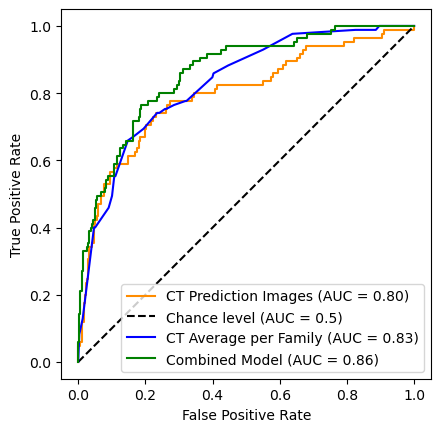

In [52]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    valid_labels,
    np.transpose(valid_probs),
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
RocCurveDisplay.from_predictions(
    valid_labels,
    np.array(valid_annot.labels).transpose(),
    name="CT Average per Family",
    color="blue",
    ax=ax
)
RocCurveDisplay.from_predictions(
    valid_labels,
    # np.ones(preds_logistic.shape[0]),
    preds_logistic[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

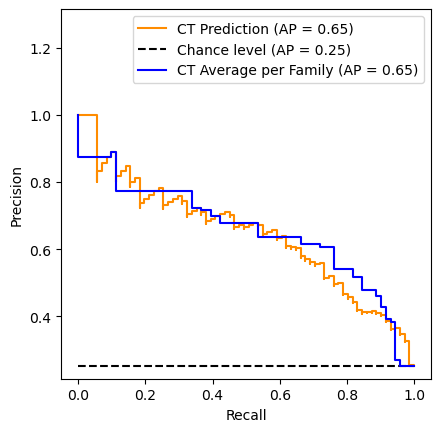

In [207]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    valid_labels,
    np.transpose(valid_probs),
    name="CT Prediction",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
PrecisionRecallDisplay.from_predictions(
    valid_labels,
    np.array(valid_data.labels).transpose(),
    name="CT Average per Family",
    color="blue",
    ax=ax
)
plt.axis("square")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("")
plt.legend()
plt.show()

Lets look into the mistakes made by this model. Since its the largest family, lets focus on GBM as its likely the fairest snapshot of model performance, and will have the most single examples of correct and incorrect predictions. 

First, lets take a look at what the predictions for GBM even are!

In [208]:
valid_preds.reshape(-1)[(valid_data.family=='glioblastoma').tolist()]

array([1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1.,
       0., 1., 0., 1., 1.])

In [209]:
valid_preds.reshape(-1)[(valid_data.family=='glioblastoma').tolist()].astype(int)

array([1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1])

In [210]:
valid_labels.reshape(-1)[(valid_data.family=='glioblastoma').tolist()]

array([1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1])

In [211]:
compute_confusion_matrix(valid_preds.reshape(-1)[(valid_data.family=='glioblastoma').tolist()].astype(int), valid_labels.reshape(-1)[(valid_data.family=='glioblastoma').tolist()])

array([[2., 8.],
       [4., 8.]])

In [212]:
false_negs = np.logical_and(valid_preds.reshape(-1) != valid_labels, valid_preds.reshape(-1)==0)

In [213]:
valid_data[false_negs].groupby('family').count()

,0,Unnamed: 0l,ING_MATERIAL_ID,uuid,slide_type,id,txt_EINSENDERDIAGNOSE,txt_TUMOR_450K_lang,max_cal,MC,subclass,importance,Unnamed: 0,idat,CT_class,probs,preds,valid_labels,labels
family,,,,,,,,,,,,,,,,,,,
PA and other MAPK LGGNT,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
astrocytoma,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
craniopharyngioma,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
embryonal tumor with multilayered rosettes,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
esthesioneuroblastoma,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
ewing sarcoma,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
glioblastoma,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
hemangiopericytoma,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
medulloblastoma_G34,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [214]:
false_pos = np.logical_and(valid_preds.reshape(-1) != valid_labels, valid_preds.reshape(-1)==1)
valid_data[false_pos].groupby('family').count()

,0,Unnamed: 0l,ING_MATERIAL_ID,uuid,slide_type,id,txt_EINSENDERDIAGNOSE,txt_TUMOR_450K_lang,max_cal,MC,subclass,importance,Unnamed: 0,idat,CT_class,probs,preds,valid_labels,labels
family,,,,,,,,,,,,,,,,,,,
ATRT,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
PA and other MAPK LGGNT,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
astrocytoma,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
control,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
ependymoma,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
ewing sarcoma,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
glioblastoma,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
hemangioblastoma,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
hemangiopericytoma,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


In [215]:
false_gbm_negs = valid_data[false_negs].query('family == "glioblastoma"')[0].tolist()

In [216]:
false_gbm_negs

['3F6F0C4C-8920-4E3F-AFA1-4E0EFF4C0F5E.h5',
 '89A59D37-C8F3-4118-A141-D3D50671BE1B.h5',
 '8AA35A69-5EB8-4335-BF37-964610B9CD8E.h5',
 'FABFB0A4-0DF9-4978-8224-AB4250A8EAD4.h5',
 'E37EE917-D1B0-4EF2-8B6F-A89E0C8E7978.h5',
 'E55F57DB-2ABB-456E-BAA0-AECC9CEDC785.h5',
 '11F0C0C0-DB4C-4C7F-981E-99C798BAB045.h5',
 '099D22F2-3539-4F6F-9C4B-96B9D443BCEE.h5']

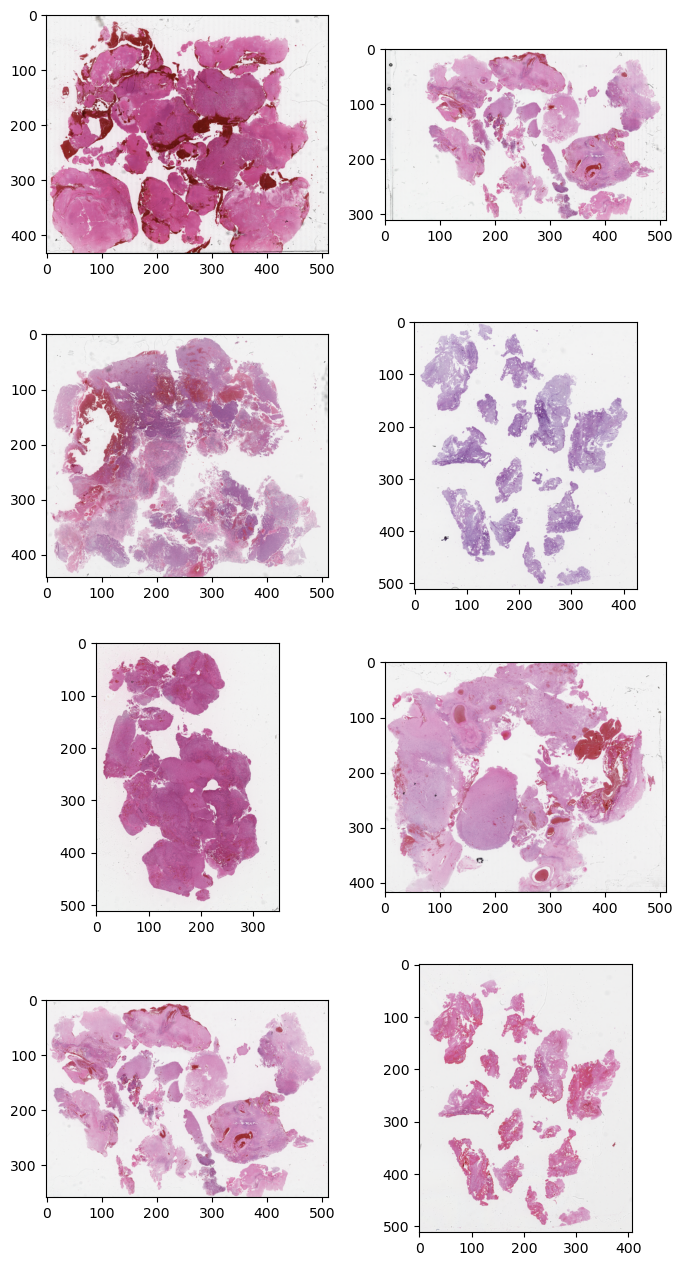

In [217]:
fig = plt.figure(figsize=(8, 16))
i = 1
for slide in false_gbm_negs:
    slide = openslide.OpenSlide('/omics/odcf/analysis/OE0606_projects/pancancer_histopathology/data/UKHD_NP_HE/' + os.path.splitext(slide)[0] + '.svs') 
    fig.add_subplot(4,2,i)
    plt.imshow(slide.get_thumbnail((512,512)))
    i = i + 1

In [277]:
valid_glio = valid_data[(valid_data.family == 'glioblastoma')]
compute_confusion_matrix(np.array(valid_glio.valid_labels), np.array(valid_glio.preds).astype(int))

array([[2., 4.],
       [8., 8.]])

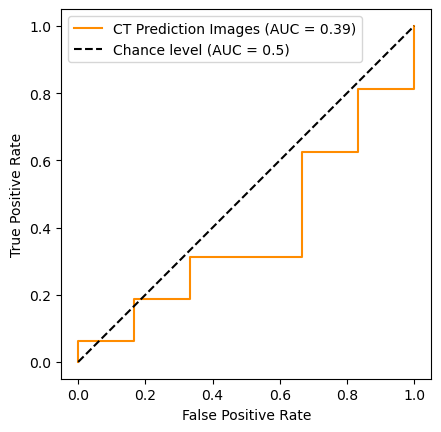

In [278]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    np.array(valid_glio.valid_labels),
    np.array(valid_glio.probs),
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

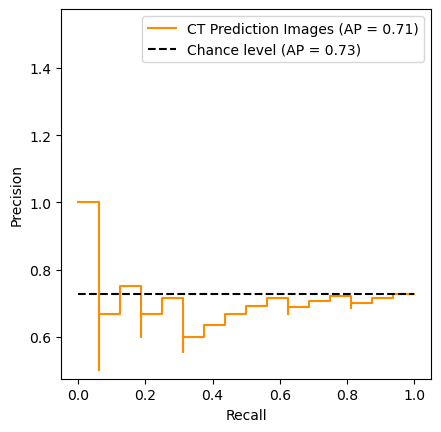

In [289]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    np.array(valid_glio.valid_labels),
    np.array(valid_glio.probs),
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
plt.axis("square")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("")
plt.legend()
plt.show()

Lets plot all the slides to see if there are any general patterns in the false negatives

In [218]:
false_neg_slides = valid_data[false_negs][0].tolist()
len(false_neg_slides)

27

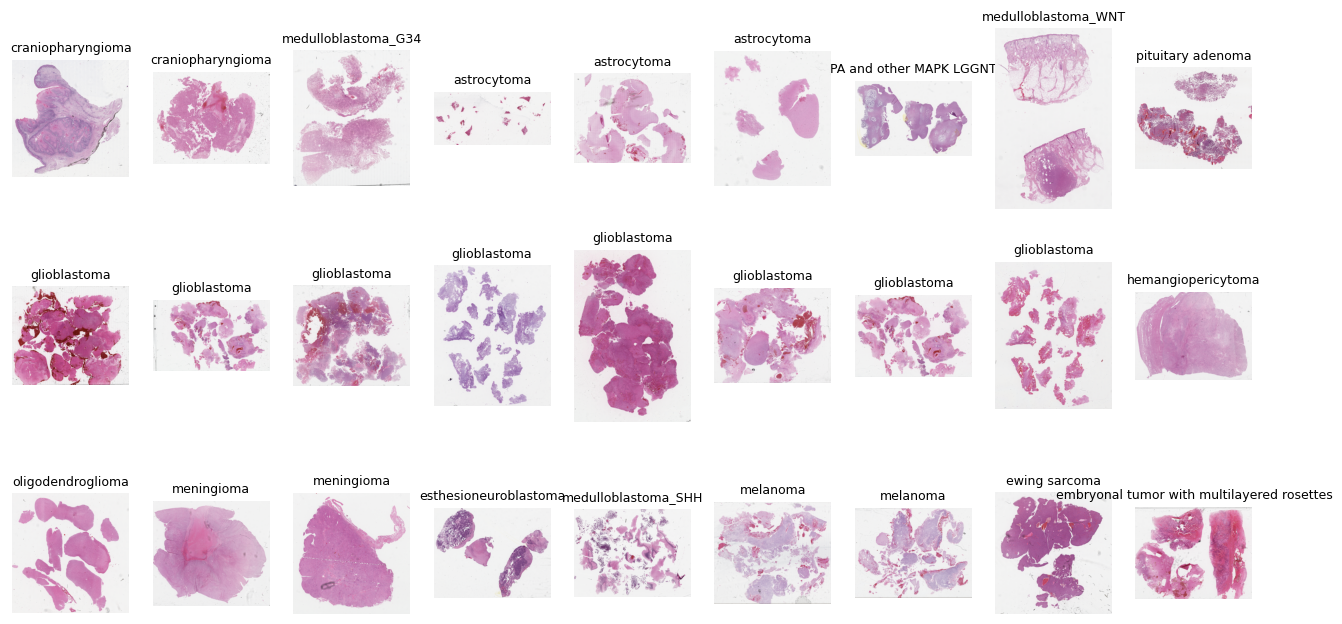

In [219]:
fig = plt.figure(figsize=(16, 8))
i = 1
for slide in false_neg_slides:
    slide = openslide.OpenSlide('/omics/odcf/analysis/OE0606_projects/pancancer_histopathology/data/UKHD_NP_HE/' + os.path.splitext(slide)[0] + '.svs') 
    fig.add_subplot(3,9,i)
    plt.imshow(slide.get_thumbnail((256,256)))
    plt.title(valid_data[valid_data[0]==false_neg_slides[i-1]].family.item(), fontsize=9)
    plt.axis('off')
    i = i + 1

Lets do the same for false positives.

In [220]:
false_pos_slides = valid_data[false_pos][0].tolist()
len(false_pos_slides)

25

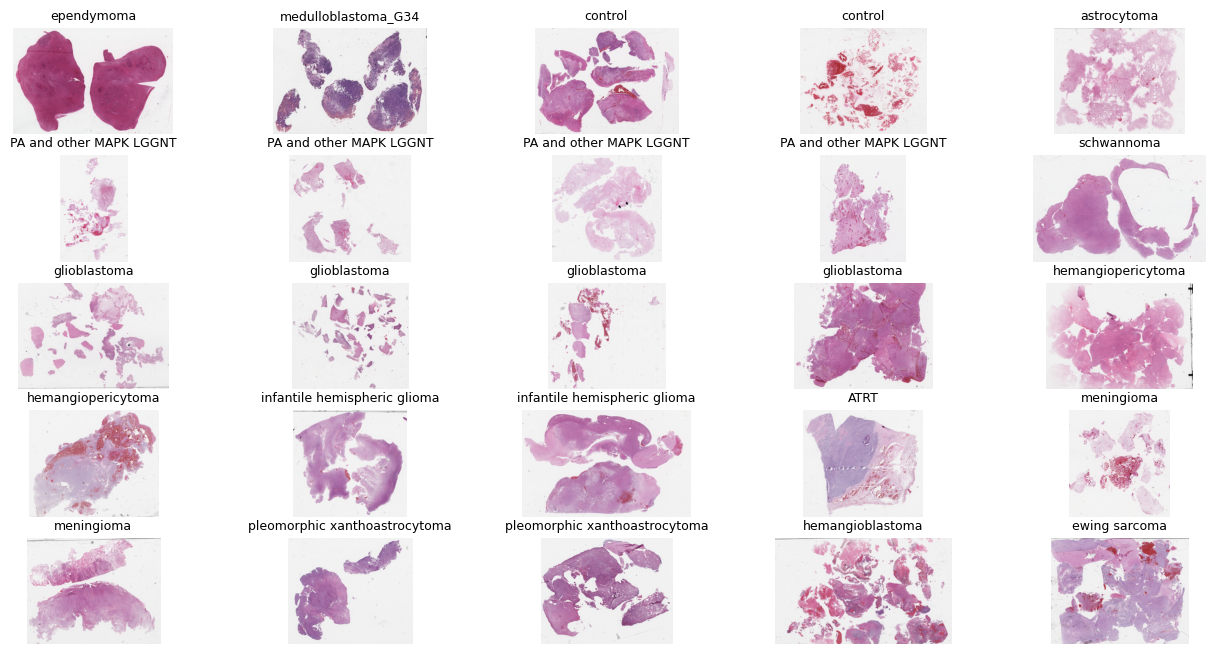

In [221]:

fig = plt.figure(figsize=(16, 8))
i = 1
for slide in false_pos_slides:
    slide = openslide.OpenSlide('/omics/odcf/analysis/OE0606_projects/pancancer_histopathology/data/UKHD_NP_HE/' + os.path.splitext(slide)[0] + '.svs') 
    fig.add_subplot(5,5,i)
    plt.imshow(slide.get_thumbnail((256,256)))
    plt.title(valid_data[valid_data[0]==false_pos_slides[i-1]].family.item(), fontsize=9)
    plt.axis('off')
    i = i + 1

Lets also find some slides where the predictions are the most confident, to examine the heatmaps. 

In [238]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

# sigmoid(valid_probs[:,valid_probs.argsort()])

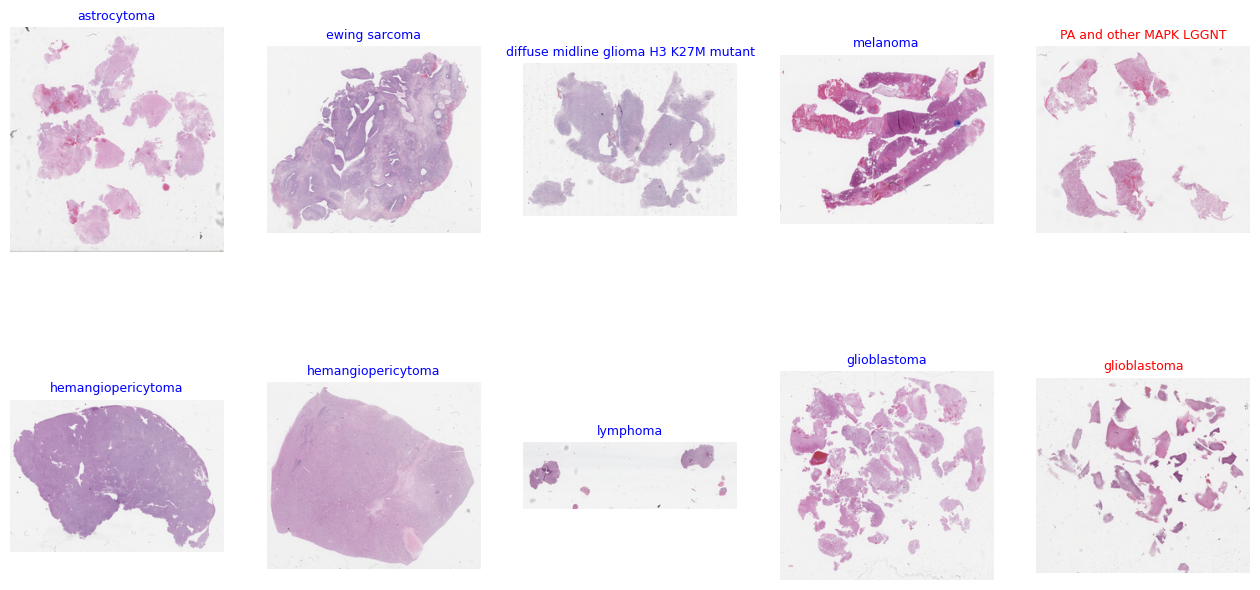

In [237]:
top_slides_10 = top_slides[0:10]
fig = plt.figure(figsize=(16, 8))
i = 1
for slide_name in top_slides_10:
    slide = openslide.OpenSlide('/omics/odcf/analysis/OE0606_projects/pancancer_histopathology/data/UKHD_NP_HE/' + os.path.splitext(slide_name)[0] + '.svs') 
    fig.add_subplot(2,5,i)
    plt.imshow(slide.get_thumbnail((256,256)))
    title_color = 'blue' if valid_data[valid_data[0]==slide_name].CT_class.item() == 'Chromothripsis' else 'red'
    plt.title(valid_data[valid_data[0]==top_slides_10[i-1]].family.item(), fontsize=9, color=title_color)
    plt.axis('off')
    i = i + 1

In [239]:
top_slides_10

array(['1E18F61A-C4E9-45F9-B729-871302CC38E6.h5',
       '13BE2007-E55E-44A7-B769-CAF64CE2211D.h5',
       'D007406B-341C-4329-9403-40EB845A2679.h5',
       '619D9517-844F-47D0-ABC4-3B76CD6E685E.h5',
       'F5C496C6-BF02-4076-9247-3FD9EF99B92F.h5',
       'C343E4CD-7E96-45C8-AB08-7E646E5C7D41.h5',
       'FB189BD1-F05A-45E7-AB7A-209144F1EE4F.h5',
       '4570CE1F-7A91-4CF7-BA0F-4CB0390BAE06.h5',
       '0F458AF1-9BE2-4F9E-82EE-D0C396150099.h5',
       '528E6FD1-425E-41EA-9416-D39201405AE4.h5'], dtype=object)

Out of interest in a tumour type where it actually helps to run the image model, lets look at medulloblastomas

In [259]:
valid_medullo = valid_data[(valid_data.family == 'medulloblastoma_SHH')| (valid_data.family == 'medulloblastoma_G34')|(valid_data.family == 'medulloblastoma_WNT')]

In [260]:
compute_confusion_matrix(np.array(valid_medullo.valid_labels), np.array(valid_medullo.preds).astype(int))

array([[10.,  1.],
       [ 3.,  6.]])

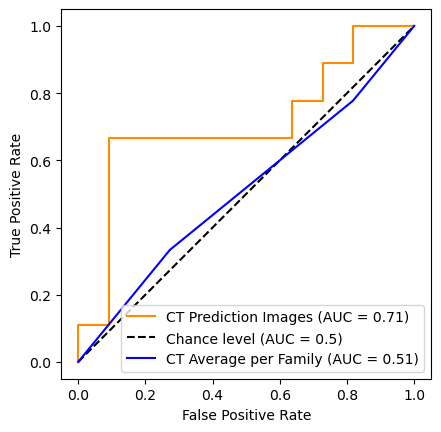

In [261]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    np.array(valid_medullo.valid_labels),
    np.array(valid_medullo.probs),
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
RocCurveDisplay.from_predictions(
    np.array(valid_medullo.valid_labels),
    np.array(valid_medullo.labels).transpose(),
    name="CT Average per Family",
    color="blue",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

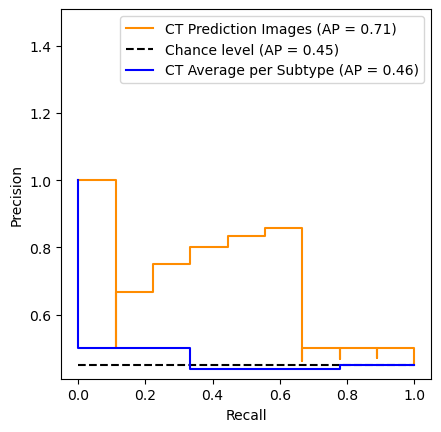

In [290]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    np.array(valid_medullo.valid_labels),
    np.array(valid_medullo.probs),
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
PrecisionRecallDisplay.from_predictions(
    np.array(valid_medullo.valid_labels),
    np.array(valid_medullo.labels).transpose(),
    name="CT Average per Subtype",
    color="blue",
    ax=ax
)
plt.axis("square")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("")
plt.legend()
plt.show()

In [267]:
valid_medullo[0].iloc[np.argmax(np.array(valid_medullo.probs))]

'C18A05A8-4D1C-4168-9ECC-2236BB52F93E.h5'

In [268]:
valid_medullo

,0,Unnamed: 0l,ING_MATERIAL_ID,uuid,slide_type,id,txt_EINSENDERDIAGNOSE,txt_TUMOR_450K_lang,max_cal,MC,subclass,family,importance,Unnamed: 0,idat,CT_class,probs,preds,valid_labels,labels
37,1E386CE2-4F71-4DE5-9CD2-73DF9678FFCB.h5,3704,72426,1E386CE2-4F71-4DE5-9CD2-73DF9678FFCB,UNKNOWN,72426,Medulloblastom,"methylation class medulloblastoma, subclass gr...",0.999864,62,"methylation class medulloblastoma, subclass gr...",medulloblastoma_G34,2,122614.0,9878827240_R03C01,No Chromothripsis,-2.878723,0.0,0,0.259259
38,013A1CFA-1CA9-4B36-BAC8-5A88842FE723.h5,3767,100876,013A1CFA-1CA9-4B36-BAC8-5A88842FE723,UNKNOWN,100876,Medulloblastom Group 4,"methylation class medulloblastoma, subclass gr...",0.994053,62,"methylation class medulloblastoma, subclass gr...",medulloblastoma_G34,2,14602.0,201465960058_R02C01,Chromothripsis,0.684912,1.0,1,0.259259
39,A5F3099F-465D-440C-A81D-B768AB78574C.h5,3752,100810,A5F3099F-465D-440C-A81D-B768AB78574C,UNKNOWN,100810,Medulloblastom Group 3,"methylation class medulloblastoma, subclass gr...",0.991844,62,"methylation class medulloblastoma, subclass gr...",medulloblastoma_G34,2,14566.0,201465960053_R06C01,Chromothripsis,0.419470,1.0,1,0.259259
40,EB7DCFE3-8E7F-4FF2-9CF9-C1AC9E300CC2.h5,3699,70610,EB7DCFE3-8E7F-4FF2-9CF9-C1AC9E300CC2,UNKNOWN,70610,Medulloblastom,"methylation class medulloblastoma, subclass gr...",0.995144,62,"methylation class medulloblastoma, subclass gr...",medulloblastoma_G34,2,124235.0,9969477088_R02C01,No Chromothripsis,-3.529829,0.0,0,0.259259
41,2C924A65-DA37-4964-9470-AAC226F2D1F3.h5,3589,65722,2C924A65-DA37-4964-9470-AAC226F2D1F3,UNKNOWN,65722,Medulloblastoma WHO grade IV,"methylation class medulloblastoma, subclass gr...",0.999923,61,"methylation class medulloblastoma, subclass gr...",medulloblastoma_G34,2,116951.0,9407201029_R06C02,No Chromothripsis,1.541322,1.0,0,0.259259
42,0350D10E-215B-4A35-813A-1A99D2564D69.h5,3676,228178,0350D10E-215B-4A35-813A-1A99D2564D69,UNKNOWN,228178,Medulloblastom (Gruppe 3 /4),"methylation class medulloblastoma, subclass gr...",0.999527,61,"methylation class medulloblastoma, subclass gr...",medulloblastoma_G34,2,57700.0,204788470021_R05C01,Chromothripsis,0.148311,1.0,1,0.259259
43,FCF0FBAE-F5DC-40EF-BB28-F7E3AC6EA45F.h5,3659,108354,FCF0FBAE-F5DC-40EF-BB28-F7E3AC6EA45F,UNKNOWN,108354,Medulloblastom (großzellig-anaplastisch),"methylation class medulloblastoma, subclass gr...",0.987757,61,"methylation class medulloblastoma, subclass gr...",medulloblastoma_G34,2,20662.0,202073190060_R08C01,No Chromothripsis,-0.777174,0.0,0,0.259259
44,E7339AD6-E674-4D6C-937D-9694D02138C6.h5,3591,67826,E7339AD6-E674-4D6C-937D-9694D02138C6,UNKNOWN,67826,Medulloblastom,"methylation class medulloblastoma, subclass gr...",0.999915,61,"methylation class medulloblastoma, subclass gr...",medulloblastoma_G34,2,121087.0,9741950085_R06C02,Chromothripsis,-1.840133,0.0,1,0.259259
45,CB4E62D2-8ED5-444F-8FCE-23E550D97762.h5,3731,83340,CB4E62D2-8ED5-444F-8FCE-23E550D97762,UNKNOWN,83340,"Medulloblastom WHO Grad IV, classic subtype","methylation class medulloblastoma, subclass gr...",0.999442,62,"methylation class medulloblastoma, subclass gr...",medulloblastoma_G34,2,2155.0,200091640033_R04C02,No Chromothripsis,-0.508064,0.0,0,0.259259
46,F17764F3-14E4-4007-83F1-D27B4EF2E918.h5,3772,105486,F17764F3-14E4-4007-83F1-D27B4EF2E918,UNKNOWN,105486,Medulloblastom,"methylation class medulloblastoma, subclass gr...",0.995104,62,"methylation class medulloblastoma, subclass gr...",medulloblastoma_G34,2,18964.0,201904640065_R01C01,No Chromothripsis,-0.019350,0.0,0,0.259259


In [288]:
valid_medullo[0].iloc[np.argmin(np.array(valid_medullo.probs))]

'1553404D-A8AE-46C0-8F86-D38E4422A08D.h5'

Another large class of tumours in the dataset are ependymomas

In [274]:
valid_epen = valid_data[(valid_data.family == 'ependymoma')]

In [275]:
compute_confusion_matrix(np.array(valid_epen.valid_labels), np.array(valid_epen.preds).astype(int))

array([[14.,  1.],
       [ 0.,  1.]])

As you can see, not many chromothriptic cases here. What about: meningiomas?

In [276]:
valid_mening = valid_data[(valid_data.family == 'meningioma')]
compute_confusion_matrix(np.array(valid_mening.valid_labels), np.array(valid_mening.preds).astype(int))

array([[11.,  2.],
       [ 2.,  1.]])